# Dimensionality Reduction

In [1]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
import scipy
from scipy import special
import time
import gif
from IPython.display import HTML
from sklearn.datasets import fetch_openml
import matplotlib.patches as mpatches


# Settings for the figures
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["animation.embed_limit"] = 400

## The notebook

In this notebook we want to look at the most abundant dimensionality reduction technique: Principle component analysis. Even much more sophisticated methods as a pre-processing step use PCA to get a first reduction of dimensionality. 
Therefore it is beneficial to get a firm understanding of the approach of PCA. We go through the same steps that have been introduced in the lecture in order to perform PCA on the MNIST dataset.

## PCA Step 0 - The data

We look at the MNIST dataset, which is a very classical dataset for machine learning where each sample is a 784 dimensional vector that represents handwritten digits from 0 to 9. It is rather outdated for modern approaches since the task of classifying the 10 digits is rather simple for the current technology but it will do perfectly well for our purposes.

First, we need to load the dataset and store the data in an array

In [2]:
mnist = fetch_openml(name='mnist_784', as_frame = False)

In [62]:
X = mnist.data

First, we look at the data:

In [63]:
print (np.max(X), np.min(X))

255.0 0.0


The maximum number is 255, the minumum number is 0. Each feature reflects a pixel and each pixel can take any integer value between these two values.

In [64]:
print (X.shape)

(70000, 784)


We see the 784 feautures and another dimension that gives us the number of samples: 70.000
Now we want to look at example samples.

To do so, we nee to reshape the 784 dimensions so that we get a 2D image again:

### Task 1 - look at some examples

Change the selected sample below to look at some examples of the digits.

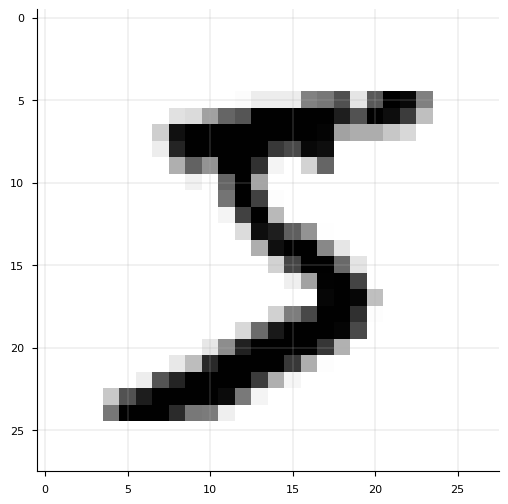

In [5]:
example_number = X[0,:]

example_number_reshaped = example_number.reshape((28,28))

# now we can visualize the number

fig, ax = plt.subplots()
ax.imshow(example_number_reshaped, cmap='binary')

We now create a function that allows us to look at any sample

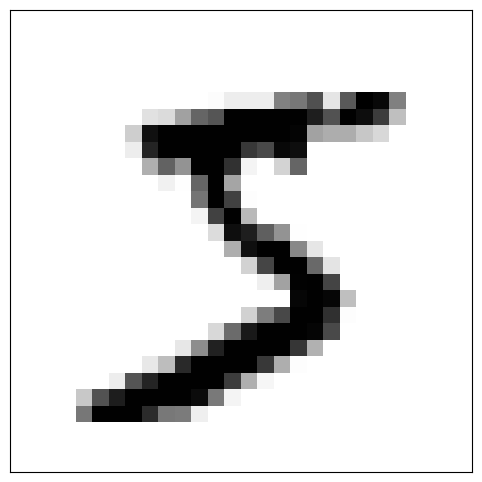

In [105]:
def visualize_number(number, ax=None, title='', style='regular'):
    if ax==None:
        fig, ax = plt.subplots()
    
    number_reshaped = number.reshape((28,28))
    
    if style == 'regular':
        cmap = 'binary'
        vmin = 0
        vmax = 255
    if style == 'mean centered':
        cmap = 'bwr'
        vmin = -255
        vmax = 255
        
    if style == 'eigenvectors':
        cmap = 'PRGn'
        max_val = np.max([np.abs(np.max(number)),np.abs(np.min(number))])
        vmin = - max_val
        vmax = max_val
        
    
    ax.imshow(number_reshaped, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.spines[['right', 'top']].set_visible(True)

    ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    
    ax.tick_params(
    axis='y',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the left edge are off
    right=False,         # ticks along the righ edge are off
    labelleft=False) # labels along the left edge are off
    
    ax.set(
    xlim = [-0.5,27.5],
    ylim = [27.5,-0.5],
    title=title)
    
    ax.grid(False)
    
visualize_number(example_number, ax=None);

We can now look at many examples of the dataset at the same time

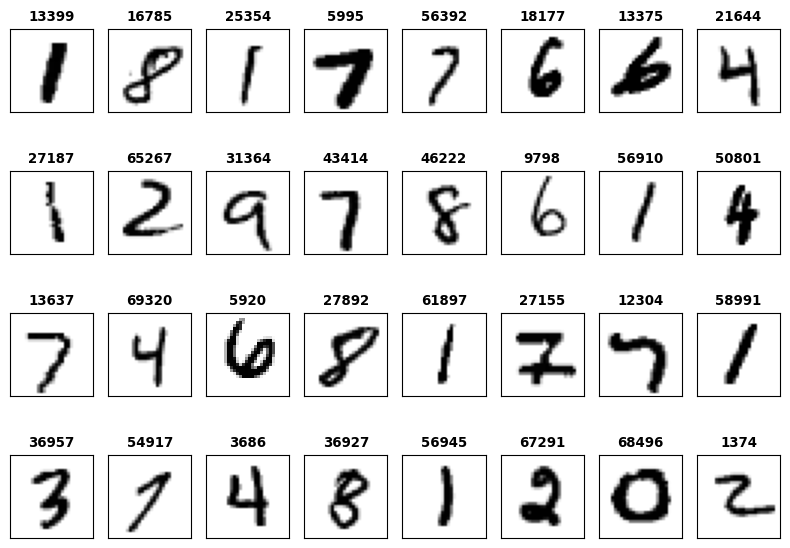

In [65]:
I, J = 4, 8
fig, ax = plt.subplots(I,J)

for ii in range(I):
    for jj in range(J):
        random_integer = int(np.random.rand()*70_000)
        random_sample = X[random_integer]
        visualize_number(random_sample, ax=ax[ii,jj], title=f'{random_integer}')
fig.tight_layout()


We now want to perform PCA on the dataset by following the steps as discussed in the lecture

## PCA Step 1 - Mean Center

Mean-centering is a crucial preprocessing step for PCA. However, first we need to make sure our data is organized in the way we want it to be.

### Task 2 - Create the feature-sample matrix

Create the feature - sample matrix as discussed in the lecture, please assing it to the variable 
```python
design_matrix
```
Then, mean-center this matrix as discussed in the lecture. You can use
```python
np.mean( A, axis = n)
```
where A is the matrix you are investigating and n gives the dimension along which you want to take the mean.
Please call the new matrix
```python
design_matrix_centered
```

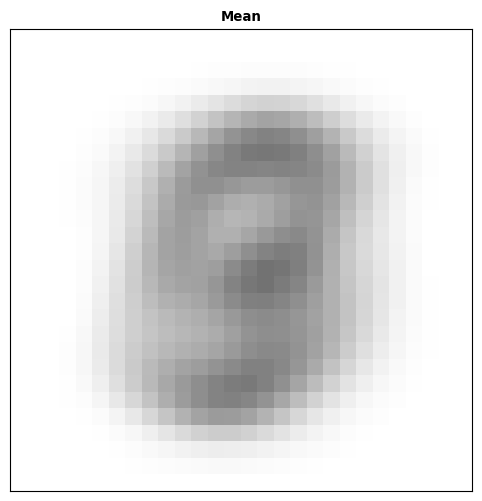

In [68]:
X_mean = np.mean(X, axis=0)
design_matrix = X
design_matrix_centered = design_matrix - X_mean
visualize_number(X_mean, title='Mean')

### [Solution 2](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_10/solutions/28gf3f83ea6ec83abd601a619efa56b3.txt)




We can now look at mean-centered samples

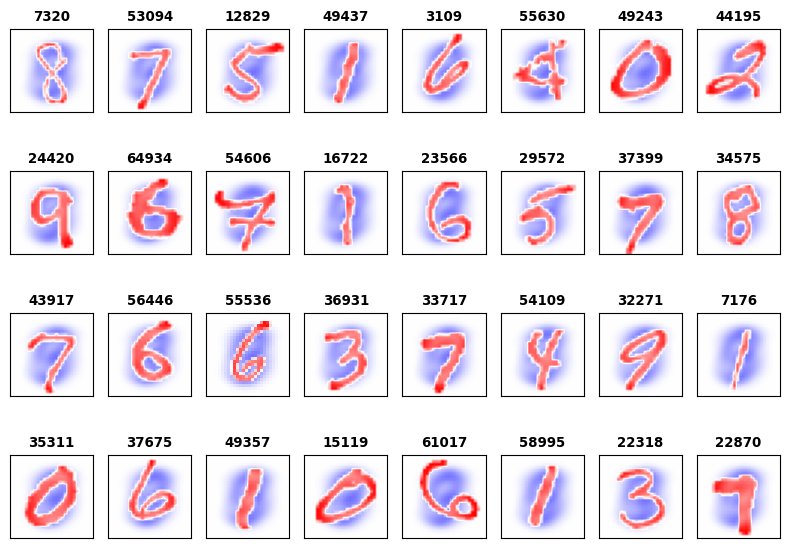

In [71]:
I, J = 4, 8
fig, ax = plt.subplots(I,J)

for ii in range(I):
    for jj in range(J):
        random_integer = int(np.random.rand()*70_000)
        random_sample = design_matrix_centered[random_integer]
        visualize_number(random_sample, ax=ax[ii,jj], title=f'{random_integer}', style='mean centered')
fig.tight_layout()



## PCA Step 2 - Calculate the Covariance Matrix


### Task 3

Now you should calculate the covariance matrix for the design matrix. Follow the lecture slides to do so.

save your result in 
```python
cov_matrix
```

you can use 
```python
example_matrix.T
```
to create the transpose of a matrix and 
```python
np.matmul(matrix_1, matrix_2)
```
to multiply two matrices


In [99]:
cov_matrix = 1 / (design_matrix_centered.shape[0]) * np.matmul(design_matrix_centered.T, design_matrix_centered)

### [Solution 3](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_10/solutions/542afb032da6b0afaggfb56a6e030b88.txt)

We can look how two pixels of the image visually are correlated across the dataset. You can change the two selected pixels down below

In [133]:
def select_pixel(ii_1=10, jj_1=10, ii_2=12,jj_2=12):
    
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
    visualize_number(design_matrix_mean, title='Mean',ax=ax1)


    
    rect= mpatches.Rectangle((ii_1-0.5,jj_1-0.5),1,1, 
                            fill=False,
                            color='#fd8d3c',
                           linewidth=1)
                           #facecolor="red")
    ax1.add_patch(rect)
    
    rect= mpatches.Rectangle((ii_2-0.5,jj_2-0.5),1,1, 
                            fill=False,
                            color='#e7298a',
                           linewidth=1)
                           #facecolor="red")
    ax1.add_patch(rect)
    
    x1 = 28 * jj_1 + ii_1
    x2 = 28 * jj_2 + ii_2
    
    # we only plot a subset (2000) of all samples to make it faster
    ax2.scatter(design_matrix_centered[:2000,x1],design_matrix_centered[:2000,x2])
    ylim = ax2.get_ylim()
    xlim = ax2.get_xlim()
    ax2.plot([xlim[0],xlim[0]],[ylim[0],ylim[1]], color='#e7298a', linewidth=5)
    ax2.plot([xlim[0],xlim[1]],[ylim[0],ylim[0]], color='#fd8d3c', linewidth=5)
    ax2.set(
        xlim = xlim,
        ylim = ylim,
        xlabel = f'Pixel {x1}',
        ylabel = f'Pixel {x2}',
        title = f'covariance = {cov_matrix[x1,x2]}')
    fig.tight_layout()

    
widgets.interactive(select_pixel, ii_1=(0,27,1),jj_1=(0,27,1),ii_2=(0,27,1),jj_2=(0,27,1))


interactive(children=(IntSlider(value=10, description='ii_1', max=27), IntSlider(value=10, description='jj_1',…

## PCA Step 3 - Find Eigenvectors and -Values

To find the eigenvectors and eigenvalues we use a scipy library.
We then have to sort these eigenvectors

In [150]:
evals, evectors = np.linalg.eigh(cov_matrix)
index = np.argsort(np.abs(evals))[::-1]
evals = evals[index]
evectors = evectors[:, index]



[-8.88299313e-31 -2.30267112e-30 -7.68859057e-30 -1.75107163e-28
 -8.24090295e-28 -9.20587462e-17 -2.11189281e-16 -3.49823976e-16
 -4.05287669e-16 -2.63207790e-15 -4.33354321e-15 -2.51508423e-14
 -3.99766033e-14 -4.51314833e-14 -1.32798016e-13 -1.95838082e-13
 -2.18511463e-13 -3.43762753e-13 -6.59340115e-13 -8.14271286e-13
 -1.45114253e-12 -2.12146352e-12 -2.32758453e-12 -2.70717773e-12
 -3.17252976e-12 -4.08661117e-12 -6.17131249e-12 -7.78887297e-12
 -1.86805199e-11 -2.33069340e-11 -2.62879750e-11]


 We can now visually look at these eigenvectors
 
 Be aware how the eigenvectors are selected. As an index we take the column value (look at the lecture how the eigenvector matrix is organized)
 
 ### Task 4 
 
 Scroll through the eigenvectors and see how the structure becomes more and more noise - and especially irrelevant noise that is outside of the main part of the image - when going to smaller eigenvalues

In [128]:
def show_eigenvector(nn):
    visualize_number(evectors[:,nn], title=f'Eigenvector {nn} - Eigenvalue = {np.round(evals[nn])}', style='eigenvectors')
widgets.interactive(show_eigenvector, nn=(0,783,1))

interactive(children=(IntSlider(value=391, description='nn', max=783), Output()), _dom_classes=('widget-intera…

### Task 5

You learned four different methods to select the number of components in the lecture. Can you find a solution for all for of them for this dataset?

### [Solution 5](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_10/solutions/a3dd6a1ac53626e00932e2aadca52865.txt)




## Step 4 - project into the new basis

to project into the new basis we multiply the normalized matrix with the weight matrix (the eigenvectors), but we include only as many components as we like

[Text(0.5, 0, 'PC 1'), Text(0, 0.5, 'PC 2')]

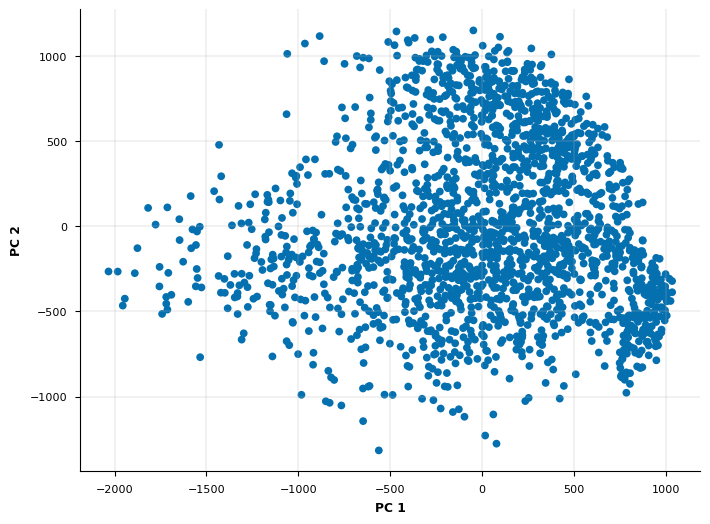

In [124]:
n_components = 4
score = np.matmul(design_matrix_centered, evectors[:,:n_components])

fig, ax = plt.subplots()
# we only show a subset of all samples
ax.scatter(score[:2000,0],score[:2000,1])
ax.set(
    xlabel='PC 1',
    ylabel='PC 2')

## Step 5 - project back into the original space

We can now multiply the projected data with the transposed of the weights to project back into the original space. To make it faster, below we only do so for the selected sample, in principle one can perform the operation for the whole set 


In [159]:
def project_back(n_components = 3, chosen_sample=0):
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3)
    score = np.matmul(design_matrix_centered[chosen_sample:chosen_sample+1,:], evectors[:,:n_components])  
    
    project_back = np.matmul(score,evectors[:,:n_components].T) + design_matrix_mean 
    
    visualize_number(number=design_matrix[chosen_sample], title='original number', ax=ax1)
    visualize_number(number=project_back, title='projection', ax=ax2)
    
    strongest_eigenvector = np.argmax(np.abs(score))
    visualize_number(number=evectors[:,strongest_eigenvector], title=f'Most strongly\ncontributing eigenvector: #{strongest_eigenvector+1}', ax=ax3, style ='eigenvectors' )


widgets.interactive(project_back, n_components=(1,784,1), chosen_sample=(0,69000,1))

interactive(children=(IntSlider(value=3, description='n_components', max=784, min=1), IntSlider(value=0, descr…

## PCA in concise form

We now put all steps in one class

In [235]:
class PCA(object):
    """
    Performs PCA on multivariate data. Eigenvalues are sorted in decreasing order

    Args:
     X (numpy array of floats) :   Data matrix each column corresponds to a
                                   different feature, each row to a different sample

    Returns:
    (numpy array of floats)    : Data projected onto the new basis
    (numpy array of floats)    : Corresponding matrix of eigenvectors
    (numpy array of floats)    : Vector of eigenvalues
    (numpy array of floats)    : projection back into the original space

    """
    def __init__(self, X):
        super(PCA, self).__init__()
        
        
        self.X = X
        
    
    def perform_pca(self, n_components = None):
        
        X = np.copy(self.X)
        
        # step 1 - mean center
        X = X - np.mean(X, 0)
        # step 2 - calculate covariance matrix
        cov_matrix = self.get_sample_cov_matrix(X)
        # step 3 - get eigenvectors and -values
        evals, evectors = np.linalg.eigh(cov_matrix)
        # ... and sort them  
        evals, evectors = self.sort_evals_descending(evals, evectors)
        # step 4 - projet onto new basis
        score = self.project_onto_pcs(X, evectors, n_components)
        # step 5 - project back
        Y = self.project_back(score, evectors, n_components)
    
    
        self.evectors = evectors
        self.evals = evals
        self.Y = Y
        self.score = score
        
        return score, evectors, evals, Y

    def get_sample_cov_matrix(self, X):
        """
        Returns the sample covariance matrix of data X.

        Args:
        X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

        Returns:
        (numpy array of floats)   : Covariance matrix
        """

        X = X - np.mean(X, 0) # we include this part
        cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)
        return cov_matrix

    def sort_evals_descending(self, evals, evectors):
        """
        Sorts eigenvalues and eigenvectors in decreasing order.

        Args:
        evals (numpy array of floats)    :   Vector of eigenvalues
        evectors (numpy array of floats) :   Corresponding matrix of eigenvectors
                                             each column corresponds to a different
                                             eigenvalue

        Returns:
        (numpy array of floats)          : Vector of eigenvalues after sorting
        (numpy array of floats)          : Matrix of eigenvectors after sorting
        """

        index = np.argsort(np.abs(evals))[::-1]
        evals = evals[index]
        evectors = evectors[:, index]

        return evals, evectors

    def project_onto_pcs(self, X, W, n_components = None):
        """
        Projects data onto the principle components.

        Args:
        X (numpy array of floats) : Data matrix each column corresponding to a
                                    different random variable
        W (numpy array of floats) : new orthonormal basis columns correspond to
                                    basis vectors
        n_components (int)        : the number of components chosen when projecting 

        Returns:
        (numpy array of floats)   : Data matrix expressed in new basis
        """
        if n_components == None:
            S = np.matmul(X, W)
        else: 
            S = np.matmul(X, W[:,:n_components])
            
        self.S = S

        return S
    
    def project_back(self, S, W, n_components = None):
        """
        Projects back into the original space.

        Args:
        X (numpy array of floats) : Data matrix each column corresponding to a
                                    different random variable
        W (numpy array of floats) : new orthonormal basis columns correspond to
                                    basis vectors
        n_components (int)        : the number of components chosen when projecting back

        Returns:
        (numpy array of floats)   : Data matrix expressed in new basis
        """
        if n_components == None:
            Y = np.matmul(S, W.T)  
        else:
            Y = np.matmul(S, W[:,:n_components].T) 

        return Y + np.mean(self.X, 0)
    
    def show_eigenvector(self, nn, title='', ax=None):
        visualize_number(self.evectors[:,nn], title=f'{title}\nEigenvector {nn} - Eigenvalue = {np.round(self.evals[nn])}', style='eigenvectors',ax=ax)
        
    def select_components(self, var_to_explain = 0.98, variant = 'cumsum', ax=None, color = 'k', label='', xlim = [0,784]):
        
        if variant == 'cumsum':
            if ax == None:
                fig, ax = plt.subplots()
            
            csum = np.cumsum(self.evals)
            # Normalize by the sum of eigenvalues
            variance_explained = csum / np.sum(self.evals)
            ax.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
                   color=color, linestyle='--',label=label)
            ax.set(
                xlabel ='Number of components',
                ylabel = 'Explaeined variance')
            
            eigenvalues_to_select = np.argmax(variance_explained > var_to_explain)
            
            ax.scatter([eigenvalues_to_select],variance_explained[eigenvalues_to_select],s=40,color=color, marker='x',label=f' {var_to_explain} var explained')
            
            
            return 
        
        if variant == 'bigger 1':
            return np.argmax(np.abs(self.evals) < 1)

        if variant == 'scree':
            # 4 - look at the scree plot
            if ax == None:
                fig, ax = plt.subplots()
                
            ax.plot(np.arange(1, len(evals) + 1), self.evals, 'o-', color=color, label=label)
            ax.set(
                xlabel ='Component',
                ylabel ='Eigenvalue',
                title = 'Scree plot',
                # change xlim to zoom in
                xlim=xlim,)

In [175]:
pca_instance = PCA(X) 
score, evectors, evals, Y = pca_instance.perform_pca(n_components = 3)

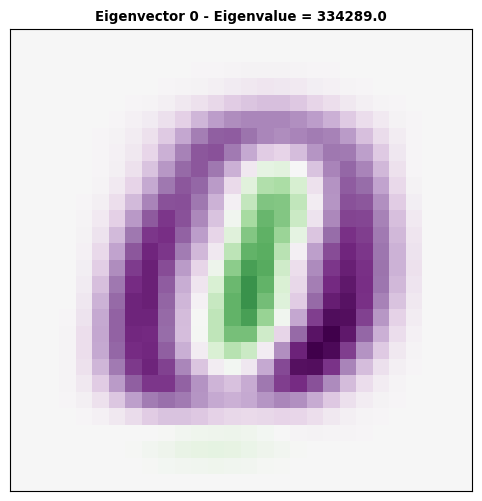

In [176]:
pca_instance.show_eigenvector(0)

## some experiments with PCA

We can see that the first eigenvector strongly characterizes the digits 0 and 1. What happens if we remove them from the dataset?

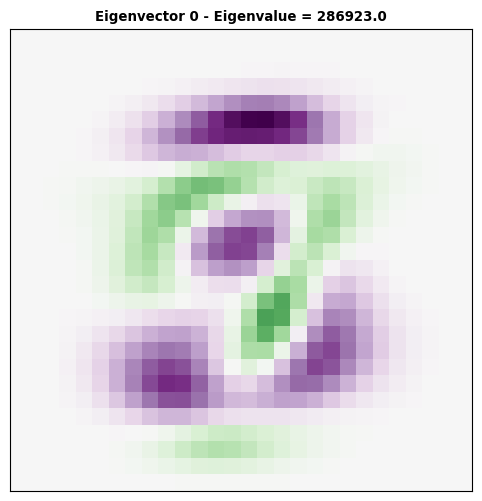

In [183]:
X_new = X[np.logical_and(mnist.target != '0', mnist.target != '1')]
pca_instance_new = PCA(X_new) 
score, evectors, evals, Y = pca_instance_new.perform_pca(n_components = 3)
pca_instance_new.show_eigenvector(0)

### Denoise using PCA


In [193]:
def add_noise(X, frac_noisy_pixels):

    X_noisy = np.reshape(X, (X.shape[0] * X.shape[1]))
    N_noise_ixs = int(X_noisy.shape[0] * frac_noisy_pixels)
    noise_ixs = np.random.choice(X_noisy.shape[0], size=N_noise_ixs,
                               replace=False)
    X_noisy[noise_ixs] = np.random.uniform(0, 255, noise_ixs.shape)
    X_noisy = np.reshape(X_noisy, (X.shape[0], X.shape[1]))

    return X_noisy

X_noisy = add_noise(X, frac_noisy_pixels=0.2)

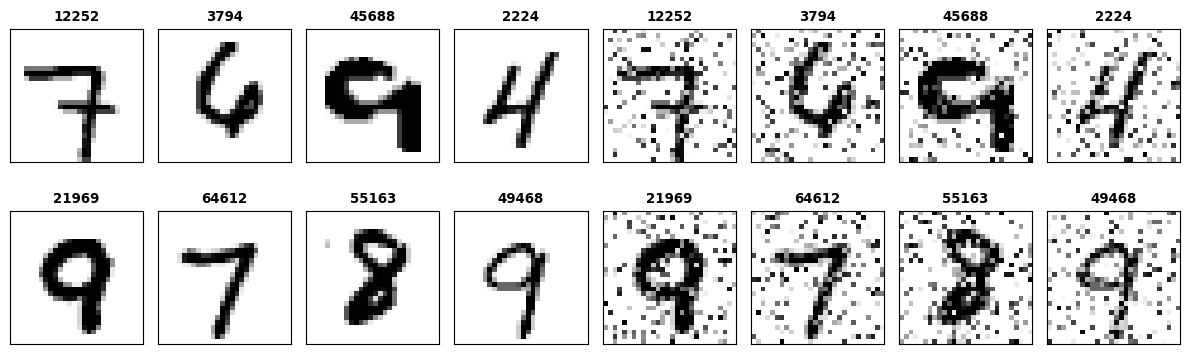

In [194]:
I, J = 2, 8
fig, ax = plt.subplots(I,J, figsize=(12,4))

for ii in range(I):
    for jj in range(J//2):
        random_integer = int(np.random.rand()*70_000)
        random_sample = X[random_integer]
        visualize_number(random_sample, ax=ax[ii,jj], title=f'{random_integer}')
        random_sample = X_noisy[random_integer]
        visualize_number(random_sample, ax=ax[ii,jj+J//2], title=f'{random_integer}')
fig.tight_layout()

In [243]:
pca_instance = PCA(X) 
score, evectors, evals, Y = pca_instance.perform_pca(n_components = 100)

pca_instance_noise = PCA(X_noisy) 
score_noise, evectors_noise, evals_noise, Y_noise = pca_instance_noise.perform_pca(n_components = 100)


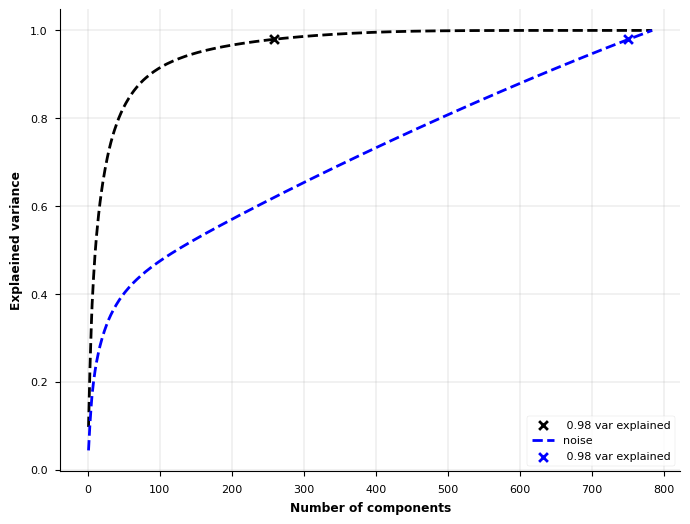

In [244]:
fig, ax = plt.subplots()
pca_instance.select_components(variant = 'cumsum',var_to_explain=0.98, ax=ax, color = 'k', label='', xlim = [0,784])

pca_instance_noise.select_components(variant = 'cumsum',var_to_explain=0.98, ax=ax, color = 'b', label='noise', xlim = [0,784])
ax.legend()

In [245]:
def compare_eigenvalues(nn=0):
    fig, (ax1,ax2) = plt.subplots(1,2)
    pca_instance_noise.show_eigenvector(nn, ax = ax1, title='Noise')
    pca_instance.show_eigenvector(nn, ax = ax2, title='Regular')
    
widgets.interactive(compare_eigenvalues, nn=(0,783,1))

interactive(children=(IntSlider(value=0, description='nn', max=783), Output()), _dom_classes=('widget-interact…

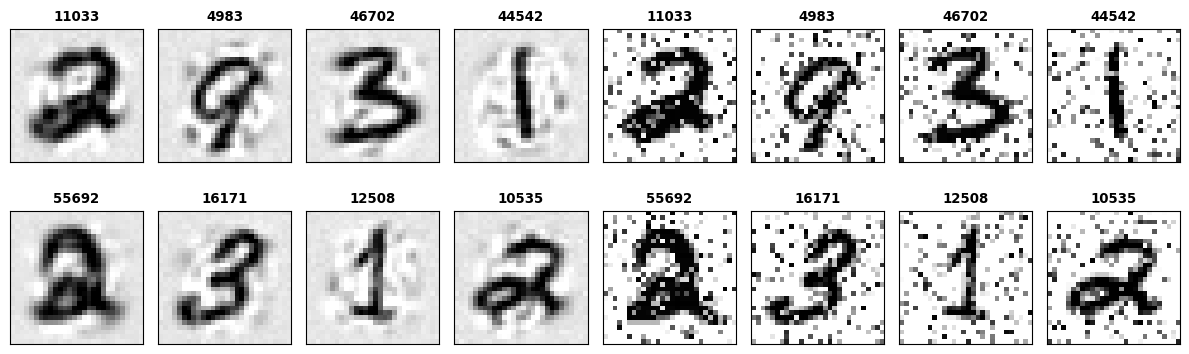

In [246]:
I, J = 2, 8
fig, ax = plt.subplots(I,J, figsize=(12,4))

for ii in range(I):
    for jj in range(J//2):
        random_integer = int(np.random.rand()*70_000)
        random_sample = X_noisy[random_integer]
        visualize_number(random_sample, ax=ax[ii,jj+J//2], title=f'{random_integer}')
        random_sample = Y_noise[random_integer]
        visualize_number(random_sample, ax=ax[ii,jj], title=f'{random_integer}')
fig.tight_layout()